In [62]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import scipy.stats as ss
from scipy.interpolate import interp1d
import pymc as pymc

rez=600

In [63]:
lynch=pd.read_csv('data/vrc01_lynch_dbr.csv')#,columns=['IC50','IC80','h'])

yunda=pd.read_csv('data/yunda_dbr.csv')#,columns=['IC50','IC80','h'])

cohort_names=['40mg/kg','10mg/kg','30mg/kg']

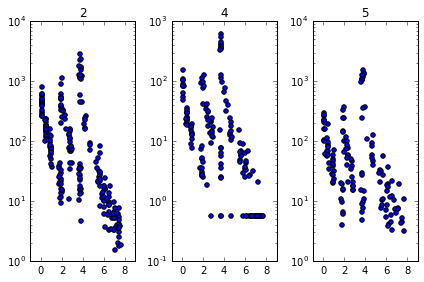

In [64]:
#plotted over full time course
#these are the 3 groups that I care about 40ug/uL 3x, 10ug/uL 3x and 30ug/uL 3x all IV doses
ing=1
for grp in [2,4,5]:
    yd=yunda[yunda.group==grp]
    plt.subplot(1,3,ing)
    for i in set(yd.ID):
        plt.scatter(yd[yd.ID==i].TIME/30,yd[yd.ID==i].DV)#,color='teal')
    ing+=1
    plt.yscale('log')
    plt.title(grp)
plt.tight_layout()    

In [4]:
#zero up all these data
#yd=yunda[(yunda.group==2) | (yunda.group==4) | (yunda.group==5)]

d_list=[]; t_list=[]; grp_ind=[]; sub_grp_ind=[0]
for grp in [2,4,5]:
    yd=yunda[yunda.group==grp]
    d=[]; t=[]

    ind=0
    for i in range(len(yd)-1):        
        if yd.occ.iloc[i+1]==yd.occ.iloc[i]:
            d.append(np.nanmax([yd.AMT.iloc[i],yd.DV.iloc[i]])) #append the value or dose depending on nans
            t.append(yd.TIME.iloc[i])
        else:
            d.append(np.nanmax([yd.AMT.iloc[i],yd.DV.iloc[i]])) #append the value or dose depending on nans
            t.append(yd.TIME.iloc[i])
            d_list.append(d); t_list.append(t)
            d=[]; t=[];
            
            sub_grp_ind.append(i)
            ind+=1
    grp_ind.append(ind)


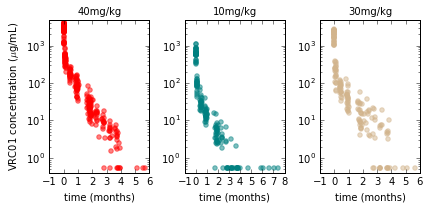

In [5]:
#should be 44 data sets total
#all time courses zeroed out
plt.figure(figsize=(6,3),dpi=rez)

c_list=['red','teal','tan']
c_ind=0
all_times=[[],[],[]]
all_concs=[[],[],[]]
for i in range(len(d_list)):        
    
    #make flattened lists
    for j in range(len(d_list[i])):
        all_times[c_ind].append(t_list[i][j]-t_list[i][0])
        all_concs[c_ind].append(d_list[i][j])        
    
    if c_ind==0:
        plt.ylabel('VRC01 concentration ($\mu$g/mL)')
    if i<np.cumsum(grp_ind)[c_ind]:
        plt.subplot(1,3,c_ind+1)
        plt.scatter((t_list[i]-t_list[i][0])/30,d_list[i],alpha=0.5,color=c_list[c_ind])
        plt.title(cohort_names[c_ind],fontsize=10)
        plt.yscale('log')
        plt.ylim([0.4,5e3])
        plt.xlabel('time (months)')
    else:
        c_ind+=1
        
    
plt.tight_layout()

In [6]:
#functino to fit pop level data, and some estimates of vals and ranges by eye

def bi_exp_fit(t,A1,k1,A2,k2):
    return A1*np.exp(-k1*t)+A2*np.exp(-k2*t)

pb0=1e3,0.5,1e2,0.01
pbounds=((10,0,1,0),(1e4,1,1e3,1))


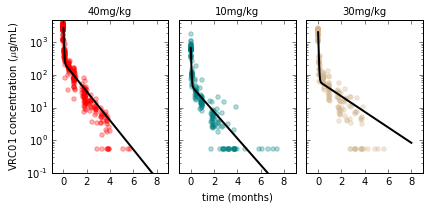

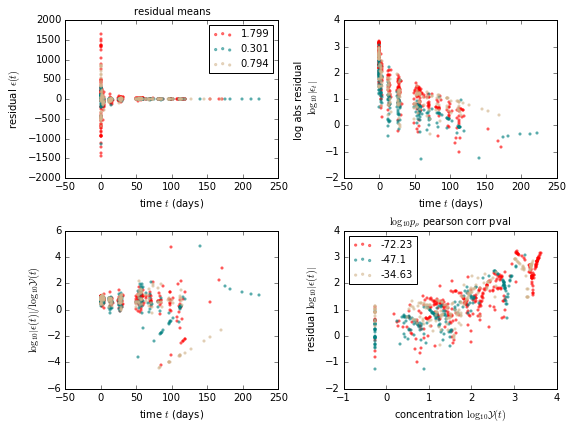

In [45]:

#do the first round of fitting
pcov_list=[]
popt_list=[]
l_list=[] #for legend
t_test=np.linspace(0,8*30,1e3)
fig,axarr=plt.subplots(1,3,sharex=True,sharey=True,figsize=(6,3),dpi=rez)
for i in range(3):        
        
    sorted_inds=np.argsort(all_times[i])  #sort time data, do I actually need to do this?  
    
    popt,pcov=opt.curve_fit(bi_exp_fit, np.array(all_times[i])[sorted_inds], np.array(all_concs[i])[sorted_inds], 
                            pb0, bounds=pbounds, ftol=1e-15, gtol=1e-15)#, maxfev=10**4)

    axarr[i].set_title(cohort_names[i],fontsize=10)
    pcov_list.append(pcov)
    popt_list.append(popt)
    A1,k1,A2,k2=popt
    conc_test = bi_exp_fit(t_test,A1,k1,A2,k2)
    l_list.append(axarr[i].scatter(np.array(all_times[i])/30,np.array(all_concs[i]),color=c_list[i],alpha=0.3))
    axarr[i].semilogy(t_test/30,conc_test,color='k',lw=2)#c_list[i]

axarr[1].set_xlabel('time (months)')
axarr[0].set_ylim([0.1,5e3])
axarr[0].set_ylabel('VRC01 concentration ($\mu$g/mL)')
plt.tight_layout()

#examine the residuals!!
res_mean=[]
err_corr=[]
err_vals=[]

plt.figure(figsize=(8,6),dpi=rez)
for i in range(3):
    A1,k1,A2,k2=popt_list[i]
    eps=bi_exp_fit(np.array(all_times[i]),A1,k1,A2,k2)-all_concs[i] #calculate residuals

    res_mean.append(np.round(np.mean(eps),3))
    
    plt.subplot(221)
    plt.scatter(all_times[i],eps,color=c_list[i],s=5,alpha=0.5)
    #plt.scatter(all_times[i],np.log10(np.abs(eps))*np.sign(eps),color=c_list[i],s=5,alpha=0.5)
    #plt.ylabel('pseudo log residual \n ' + r'$\log_{10}|\epsilon_t| \times \mathrm{sgn}(\epsilon_t)$')
    plt.xlabel('time $t$ (days)')
    plt.ylabel('residual $\epsilon(t)$')
    
    plt.subplot(222)
    plt.scatter(all_times[i],np.log10(np.abs(eps)),color=c_list[i],s=5,alpha=0.5)
    plt.ylabel('log abs residual \n $\log_{10}|\epsilon_t|$')
    plt.xlabel('time $t$ (days)')

    plt.subplot(223)
    plt.scatter(all_times[i],np.log10(np.abs(eps))/np.log10(all_concs[i]),color=c_list[i],s=5,alpha=0.5)
    plt.xlabel('time $t$ (days)')
    plt.ylabel('$\log_{10}|\epsilon(t)|/\log_{10}\mathcal{Y}(t)$')
    #plt.semilogy()
    
    plt.subplot(224)
    plt.scatter(np.log10(all_concs[i]),np.log10(np.abs(eps)),color=c_list[i],s=5,alpha=0.5)
    #plt.scatter(all_concs[i],eps,color=c_list[i],s=5,alpha=0.5)
    
    err_corr.append(np.round(np.log10(ss.pearsonr(np.log10(all_concs[i]),np.log10(np.abs(eps)))[1]),2))
    
    err_vals.append(eps)

    plt.ylabel('residual $\log_{10}|\epsilon(t)|$')
    plt.xlabel('concentration $\log_{10}\mathcal{Y}(t)$')
    plt.xlim([-1,4])

plt.subplot(221)
plt.legend(res_mean,fontsize=10)
plt.title('residual means',fontsize=10)

plt.subplot(224)
plt.legend(err_corr,fontsize=10,loc=2)
plt.title(r'$\log_{10} p_\rho$ pearson corr pval',fontsize=10)

plt.tight_layout()
plt.savefig('figures/residuals1.pdf')


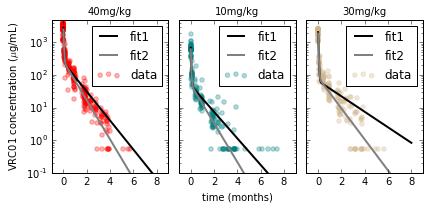

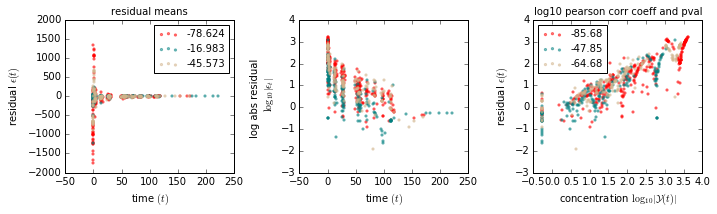

In [19]:
#so I think that means that error is not constant over time, retry with basically log error \propto log val, or err=val

popt_list2=[]
pcov_list2=[]
fig,axarr=plt.subplots(1,3,sharex=True,sharey=True,figsize=(6,3),dpi=rez)
for i in range(3):        
        
    sorted_inds=np.argsort(all_times[i])  #sort time data, do I actually need to do this?  
    
    popt,pcov=opt.curve_fit(bi_exp_fit, np.array(all_times[i])[sorted_inds], np.array(all_concs[i])[sorted_inds],  
                            pb0, bounds=pbounds, ftol=1e-15, gtol=1e-15,
                               sigma = np.sqrt(np.array(all_concs[i])[sorted_inds]))#*err_corr[i][0]) #NEW LINE!

    pcov_list2.append(pcov)
    axarr[i].set_title(cohort_names[i],fontsize=10)

    #first the old ones
    A1,k1,A2,k2=popt_list[i]
    conc_test = bi_exp_fit(t_test,A1,k1,A2,k2)
    axarr[i].semilogy(t_test/30,conc_test,color='k',lw=2)#c_list[i]

    #now the new fits
    popt_list2.append(popt)
    A1,k1,A2,k2=popt
    conc_test2 = bi_exp_fit(t_test,A1,k1,A2,k2)
    axarr[i].semilogy(t_test/30,conc_test2,color='gray',lw=2)#c_list[i]

    #and the data
    axarr[i].scatter(np.array(all_times[i])/30,np.array(all_concs[i]),color=c_list[i],alpha=0.3)

    axarr[i].legend(['fit1','fit2','data'])

axarr[1].set_xlabel('time (months)')
axarr[0].set_ylim([0.1,5e3])
axarr[0].set_ylabel('VRC01 concentration ($\mu$g/mL)')
plt.tight_layout()
plt.savefig('figures/2nd_fits.pdf')

res_mean=[]
err_corr=[]
plt.figure(figsize=(10,3),dpi=rez)
for i in range(3):
    A1,k1,A2,k2=popt_list2[i]
    eps=bi_exp_fit(np.array(all_times[i]),A1,k1,A2,k2)-all_concs[i]

    res_mean.append(np.round(np.mean(eps),3))
    
    plt.subplot(131)
    plt.scatter(all_times[i],eps,color=c_list[i],s=5,alpha=0.5)
    #plt.scatter(all_times[i],np.log10(np.abs(eps))*np.sign(eps),color=c_list[i],s=5,alpha=0.5)
    #plt.ylabel('pseudo log residual \n ' + r'$\log_{10}|\epsilon_t| \times \mathrm{sgn}(\epsilon_t)$')
    plt.xlabel('time $(t)$')
    plt.ylabel('residual $\epsilon(t)$')

    plt.subplot(132)
    plt.scatter(all_times[i],np.log10(np.abs(eps)),color=c_list[i],s=5,alpha=0.5)
    plt.ylabel('log abs residual \n $\log_{10}|\epsilon_t|$')
    plt.xlabel('time $(t)$')

    plt.subplot(133)
    plt.scatter(np.log10(all_concs[i]),np.log10(np.abs(eps)),color=c_list[i],s=5,alpha=0.5)
    
    err_corr.append(np.round(np.log10(ss.pearsonr(np.log10(all_concs[i]),np.log10(np.abs(eps)))[1]),2))
    
    plt.ylabel('residual $\epsilon(t)$')
    plt.xlabel('concentration $\log_{10}|\mathcal{Y}(t)|$')
    

plt.subplot(131)
plt.legend(res_mean,fontsize=10)
plt.title('residual means',fontsize=10)

plt.subplot(133)
plt.legend(err_corr,fontsize=10,loc=2)
plt.title(r'$\log_{10} p_\rho$ pearson corr pval',fontsize=10)

plt.tight_layout()
plt.savefig('figures/residuals.pdf')


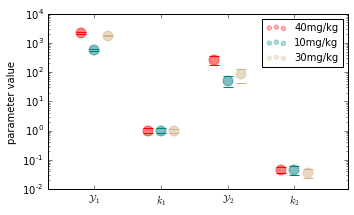

In [42]:
#plot summary of fits

param_names=['$\mathcal{Y}_1$','$k_1$','$\mathcal{Y}_2$','$k_2$']
plt.figure(figsize=(5,3),dpi=rez)
for i in range(3):
    for j in range(4):
        
        mu=popt_list2[i][j] #mean val
        CI=2*np.sqrt(np.diag(pcov_list2[i]))[j] #2 sigma or ~95%
        
        plt.scatter(j+i*0.2,mu,marker='o',color=c_list[i],s=100,alpha=0.5)
        plt.scatter(j+i*0.2,mu+CI,marker='_',color=c_list[i],s=100)
        plt.scatter(j+i*0.2,mu-CI,marker='_',color=c_list[i],s=100)
        
plt.legend(l_list,cohort_names,fontsize=10)
plt.yscale('log')
plt.ylabel('parameter value')
plt.xticks(np.arange(4)+0.2,param_names)
plt.tight_layout()
plt.savefig('figures/pk_param_vals.pdf')

/Users/danielreeves/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


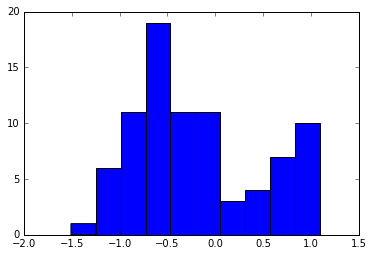

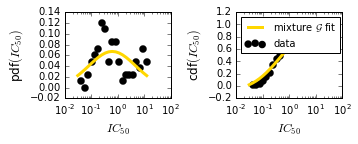

In [47]:
data=np.log10(lynch.IC50)
plt.hist(data)

p_x,x = np.histogram(np.log10(lynch.IC50),bins=20)

p0=2,0.2, 1, 8, 1

def bimodal(x,scl,mu1,sig1,mu2,sig2):
    gmix=scl*ss.norm.pdf(x,mu1,sig1)+ss.norm.pdf(x,mu2,sig2)
    return gmix/sum(gmix) #make it a probability

def fit_cdf(logIC80,scl,mu1,sig1,mu2,sig2):
    pdf=bimodal(logIC80,scl,mu1,sig1,mu2,sig2)
    return np.cumsum(pdf)
    
#fit the cdfs
popt=opt.curve_fit(fit_cdf, x[1:], np.cumsum(p_x/sum(p_x)), p0, ftol=1e-10, gtol=1e-10, maxfev=10**4)

scl,mu1,sig1,mu2,sig2=popt[0]
p_fit=bimodal(x,scl,mu1,sig1,mu2,sig2)

plt.figure(figsize=(5,2),dpi=rez)

plt.subplot(121)
plt.scatter(10**x[1:],p_x/sum(p_x),lw=3,color='k')
plt.semilogx(10**x,p_fit,lw=3,color='gold')
#plt.xlabel('$IC_{80}$',fontsize=12)
plt.ylabel('pdf$(IC_{50})$',fontsize=12)
plt.xlabel('$IC_{50}$',fontsize=12)

plt.subplot(122)
cdf=fit_cdf(x,scl,mu1,sig1,mu2,sig2)
plt.scatter(10**x[1:],np.cumsum(p_x/sum(p_x)),lw=3,color='k')
plt.semilogx(10**x,np.cumsum(p_fit/sum(p_fit)),lw=3,color='gold')
plt.xlabel('$IC_{50}$',fontsize=12)
plt.ylabel('cdf$(IC_{50})$',fontsize=12)
plt.legend([r'mixture $\mathcal{G}$ fit','data'],loc=2,fontsize=10)
#plt.xlim([-1,2])

plt.tight_layout()
plt.savefig('figures/fit_dist.pdf')  # No warning now


(array([ 7240.,   358.,   354.,   496.,   285.,   282.,   366.,   118.,
          271.,   230.]),
 array([  0.03106034,   1.25777844,   2.48449655,   3.71121465,
          4.93793276,   6.16465086,   7.39136897,   8.61808707,
          9.84480518,  11.07152328,  12.29824139]),
 <a list of 10 Patch objects>)

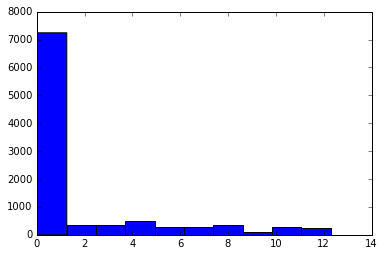

In [51]:
import scipy.interpolate as interpolate

nbins=20
hist, bin_edges = np.histogram(lynch.IC50, bins=nbins, density=True)
cum_values = np.zeros(bin_edges.shape)
cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
inv_cdf = interpolate.interp1d(cum_values, bin_edges)
r = np.random.rand(10000)
plt.hist(inv_cdf(r))


In [ ]:
#functions for Ab IC80
def response80(dose,IC80,hill):
    IC50 = IC80*4**(1/hill) 
    res = 1/(1+(dose/IC50)**-hill)
    return res

plt.figure(figsize=(3,4),dpi=rez)
#data?
dose_response=pd.read_csv('data/vrc01_doseresponse.csv',names=['dose','response'])
plt.scatter(dose_response['dose'],dose_response['response'],color='k')

hmin,hmax=0.8,1.8

#all from Lynch
dose=np.logspace(-3,3,100)
for i in range(len(log80)):
    plt.plot(dose,response80(dose,10**log80[i],np.random.uniform(hmin,hmax)),color='gray',alpha=0.3)

plt.xlabel('dose concentration ($\mu$g/$\mu$L)')
plt.ylabel('response (proportion inhibited)')
plt.xscale('log')
plt.xlim([0.01,1e3])

plt.tight_layout()
plt.gcf().savefig('figures/doseresponse.pdf')  # No warning now


(array([  5.,   3.,   7.,   5.,   1.,   3.,  11.,   1.,   9.,   5.]),
 array([  0.484 ,   1.6656,   2.8472,   4.0288,   5.2104,   6.392 ,
          7.5736,   8.7552,   9.9368,  11.1184,  12.3   ]),
 <a list of 10 Patch objects>)

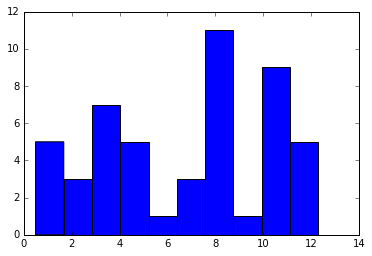

In [61]:
plt.hist(np.array(lynch.IC50[np.random.choice(len(lynch.IC50),50,p=lynch.IC50/sum(lynch.IC50))]))

(array([ 60.,   3.,   3.,   4.,   2.,   3.,   3.,   1.,   2.,   2.]),
 array([  0.031 ,   1.2579,   2.4848,   3.7117,   4.9386,   6.1655,
          7.3924,   8.6193,   9.8462,  11.0731,  12.3   ]),
 <a list of 10 Patch objects>)

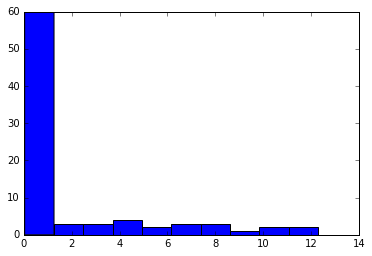

In [57]:
plt.hist(lynch.IC50)

In [ ]:
#plot proportion inhibited over time
t=np.linspace(0,55,1e3)

R0=3

fig,axarr=plt.subplots(2,2,sharex=True,dpi=rez,figsize=(5,5))

c1,c2,r1,r2=popt10 #10mg/kg range
Ab=Ab_conc(t,c1,c2,r1,r2)
for i in range(len(log80)):
    axarr[0][0].plot(t/7,response80(Ab,10**log80[i],np.random.uniform(hmin,hmax)),color='teal',alpha=0.3)    
    axarr[1][0].plot(t/7,R0*(1-response80(Ab,10**log80[i],np.random.uniform(hmin,hmax))),color='teal',alpha=0.3)    
axarr[0][0].plot(t/7,response80(Ab,10**np.median(log80),np.random.uniform(hmin,hmax)),color='black')    
axarr[1][0].plot(t/7,R0*(1-response80(Ab,10**np.median(log80),np.random.uniform(hmin,hmax))),color='black')    

c1,c2,r1,r2=popt30 #30mg/kg range
Ab=Ab_conc(t,c1,c2,r1,r2)
for i in range(len(log80)):
    axarr[0][1].plot(t/7,response80(Ab,10**log80[i],np.random.uniform(hmin,hmax)),color='tan',alpha=0.3)    
    axarr[1][1].plot(t/7,R0*(1-response80(Ab,10**log80[i],np.random.uniform(hmin,hmax))),color='tan',alpha=0.3)    
    
axarr[0][1].plot(t/7,response80(Ab,10**np.median(log80),np.random.uniform(hmin,hmax)),color='black')    
axarr[1][1].plot(t/7,R0*(1-response80(Ab,10**np.median(log80),np.random.uniform(hmin,hmax))),color='black')    

for j in range(2):
    axarr[1][j].set_xlabel('time (weeks)')
    axarr[1][j].axhline(1,color='k',lw=3)

axarr[0][0].set_title('10 mg/kg')
axarr[0][1].set_title('30 mg/kg')
axarr[0][0].set_ylabel('bnAb Effect $E(t)$')
axarr[1][0].set_ylabel('Basic reproductive number \n $\mathcal{R}(Ab,t)$')#,fontsize=13)
axarr[0][0].set_xticks(range(9))

plt.tight_layout()
plt.savefig('figures/inhibition_R0.pdf')  # No warning now


In [ ]:
#100 theoretical curves drawing from all distributions

